# Bayesian Inference

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style('whitegrid')
sns.set_context('poster')
pd.options.display.max_columns = 30

In [2]:
all_teams = pd.read_csv('../data/all-teams-1990-2016.csv')

In [3]:
all_teams.head()

,date,team_x,opponent,div_rank,gb,time,attendance,streak,double_header,runs_pg,runs_ma,runs_allowed_ma,ten_game,opening_day,total_games,win_pct,night_game,year,month,day,weekday,weekday_name,stadium,capacity,bat_age,pitch_age,division_game
0,1997-04-02,ANA,BOS,0,0.0,0 days 03:47:00.000000000,30874,0,0,0.000000,0.0,5.8,0.0,1,0,0.000000,1,1997,4,2,2,Wednesday,Angel Stadium,33851,29.7,28.3,0
1,1997-04-03,ANA,BOS,3,-1.0,0 days 02:07:00.000000000,17323,-1,0,5.000000,5.0,5.8,0.0,0,1,0.000000,1,1997,4,3,3,Thursday,Angel Stadium,33851,29.7,28.3,0
2,1997-08-22,ANA,BOS,2,-2.5,0 days 03:25:00.000000000,24977,-3,0,5.273438,4.8,5.0,0.3,0,128,0.539062,1,1997,8,22,4,Friday,Angel Stadium,33851,29.7,28.3,0
3,1997-08-23,ANA,BOS,2,-2.5,0 days 02:49:00.000000000,20994,1,0,5.294574,6.2,5.6,0.4,0,129,0.542636,0,1997,8,23,5,Saturday,Angel Stadium,33851,29.7,28.3,0
4,1997-08-24,ANA,BOS,2,-1.5,0 days 02:36:00.000000000,20733,2,0,5.300000,5.0,5.0,0.4,0,130,0.546154,0,1997,8,24,6,Sunday,Angel Stadium,33851,29.7,28.3,0


In [4]:
import pymc3 as pm
import pydot

Couldn't import dot_parser, loading of dot files will not be possible.


### Comparing Saturday Games to Wednesday Games

In [5]:
sat = all_teams[all_teams.weekday_name == 'Saturday'].attendance.values
wed = all_teams[all_teams.weekday_name == 'Wednesday'].attendance.values

In [6]:
prior = all_teams[(all_teams.weekday_name != 'Saturday') & (all_teams.weekday_name != 'Wednesday')].attendance.values

In [7]:
prior_mean = np.mean(prior)
prior_std = np.std(prior)

In [8]:
print prior_mean
print prior_std

29235.6916758
11389.5899665


In [9]:
with pm.Model() as model:

    sat_mean = pm.Normal('sat_mean', prior_mean, sd=prior_std)
    wed_mean = pm.Normal('wed_mean', prior_mean, sd=prior_std)

In [10]:
std_prior_lower = 5000.0
std_prior_upper = 15000.0

with model:
    
    sat_std = pm.Uniform('sat_std', lower=std_prior_lower, upper=std_prior_upper)
    wed_std = pm.Uniform('wed_std', lower=std_prior_lower, upper=std_prior_upper)

In [11]:
with model:

    grp_sat = pm.Normal('group_sat', mu=sat_mean, sd=sat_std, observed=sat)
    grp_wed = pm.Normal('group_wed', mu=wed_mean, sd=wed_std, observed=wed)

In [12]:
with model:

    diff_of_means = pm.Deterministic('difference of means', sat_mean - wed_mean)
    diff_of_stds = pm.Deterministic('difference of stds', sat_std - wed_std)
    effect_size = pm.Deterministic('effect size', diff_of_means / np.sqrt((sat_std**2 + wed_std**2) / 2))

In [13]:
with model:
    trace = pm.sample(20000, njobs=-1)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -2.1055e+05: 100%|██████████| 200000/200000 [01:34<00:00, 2107.18it/s]
Finished [100%]: Average ELBO = -2.1055e+05
100%|██████████| 20000/20000 [01:39<00:00, 200.95it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11a322e10>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11b8d2950>], dtype=object)

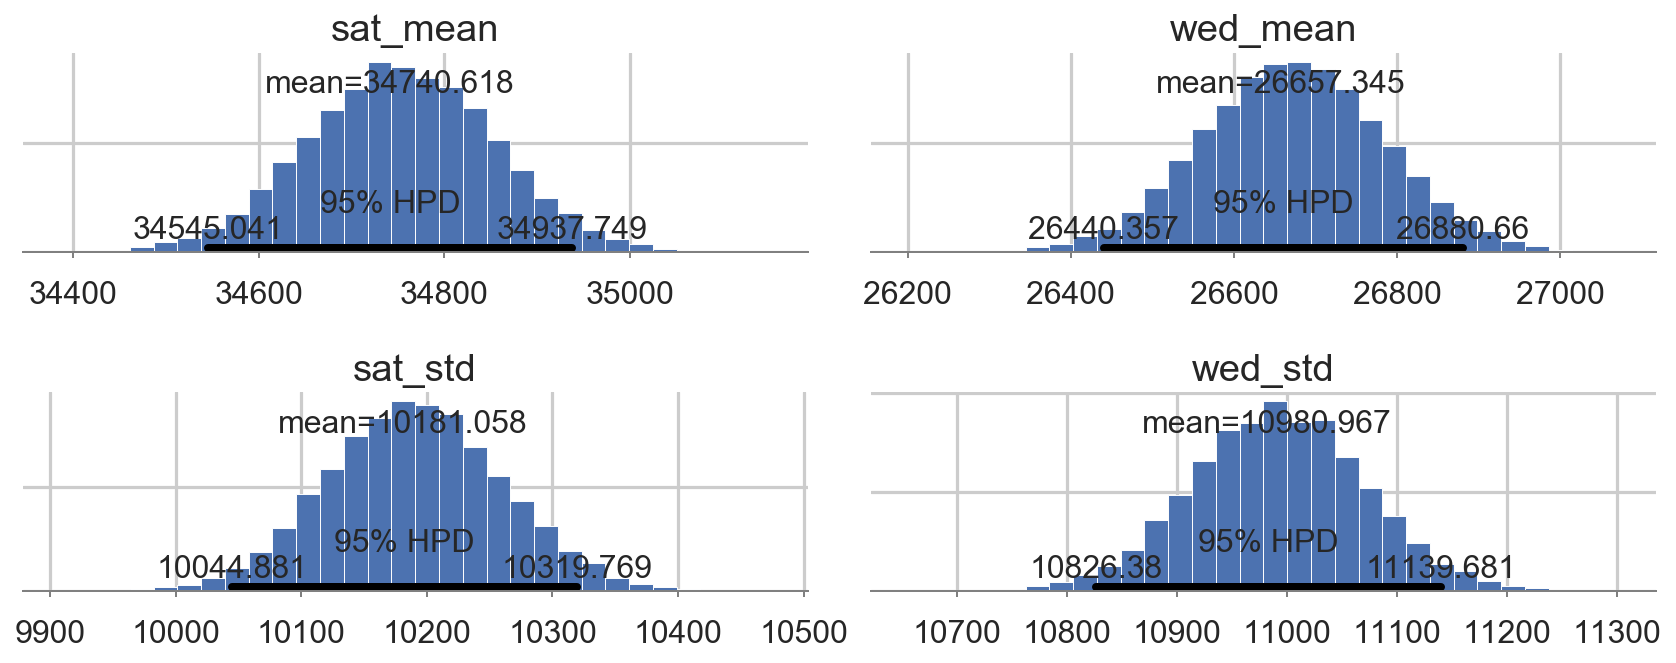

In [14]:
pm.plot_posterior(trace[3000:], varnames=['sat_mean', 'wed_mean', 'sat_std', 'wed_std'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11b7c0b10>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11d28b490>], dtype=object)

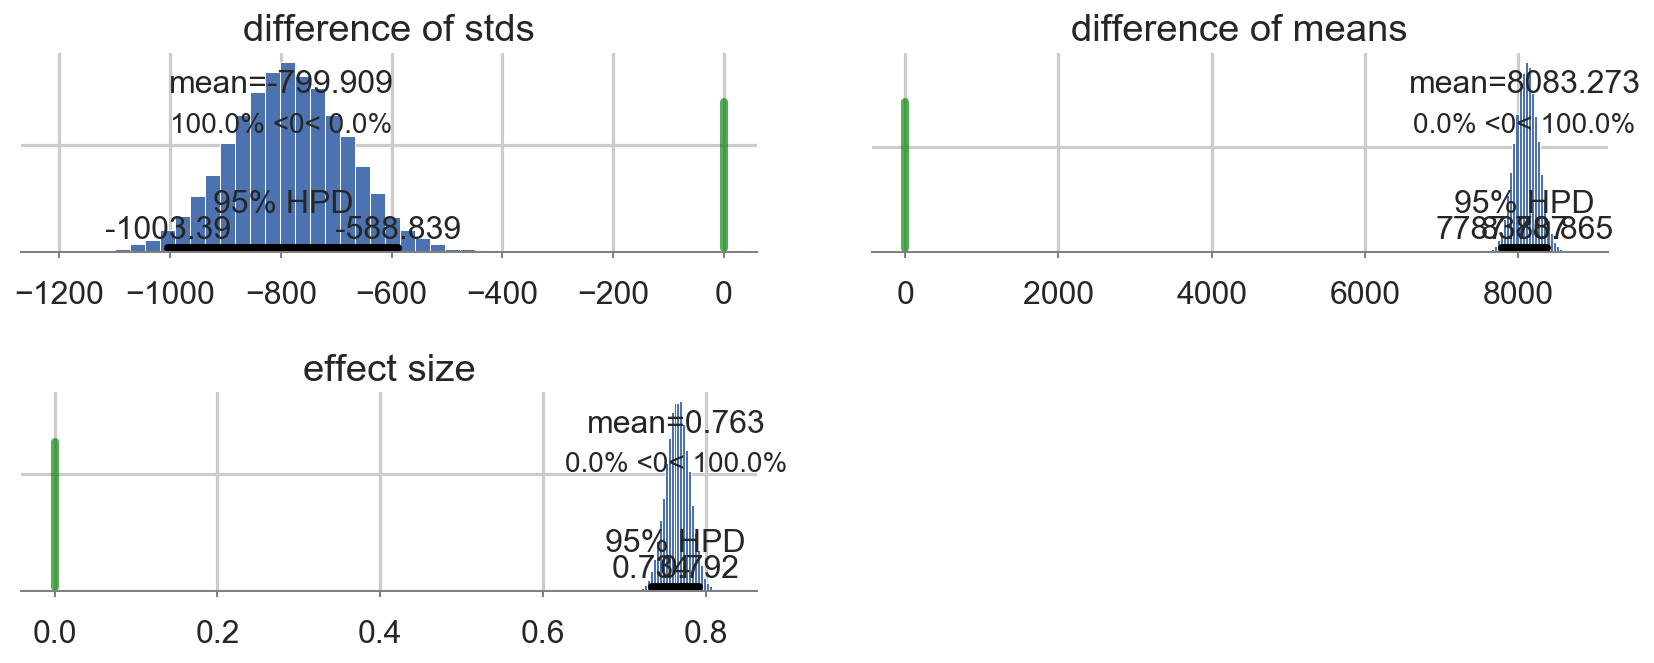

In [15]:
pm.plot_posterior(trace[3000:], varnames=['difference of means', 'difference of stds', 'effect size'], ref_val=0)

### Comparing Two Fan Groups

In [16]:
yearly = pd.read_csv('../data/yearly-team-data.csv')

In [17]:
yearly.head()

,team,year,stadium,capacity,team_name,division,G,win_pct,gb,playoffs,attendance,bat_age,pitch_age,top_player,WAR,num_home_games,avg_att_pg
0,ANA,1997,Angel Stadium,33851,Anaheim Angels,AL West,162,0.519,6.0,0,1767330,29.7,28.3,T.Salmon,4.9,81.0,21818.888889
1,ANA,1998,Angel Stadium,45050,Anaheim Angels,AL West,162,0.525,3.0,0,2519280,28.7,29.8,C.Finley,7.2,81.0,31102.222222
2,ANA,1999,Angel Stadium,45050,Anaheim Angels,AL West,162,0.432,25.0,0,2253123,28.8,31.5,R.Velarde,4.2,81.0,27816.333333
3,ANA,2000,Angel Stadium,45050,Anaheim Angels,AL West,162,0.506,9.5,0,2066982,27.7,28.9,D.Erstad,8.3,81.0,25518.296296
4,ANA,2001,Angel Stadium,45050,Anaheim Angels,AL West,162,0.463,41.0,0,2000919,28.0,28.9,T.Glaus,5.2,81.0,24702.703704


In [18]:
active_parks = yearly
for i in yearly.stadium.unique():
    if i not in yearly[yearly.year == 2016].stadium.unique():
        active_parks = active_parks[active_parks.stadium != i]

In [19]:
parks_summary = pd.DataFrame(columns=['stadium', 'first_year', 'avg_capacity', 'capacity_std', 'avg_win_pct', 'avg_attendance'])
for i in active_parks.stadium.unique():
    parks_summary.loc[len(parks_summary)] = [
        i,
        min(active_parks[active_parks.stadium == i].year),
        round(np.mean(active_parks[active_parks.stadium == i].capacity),0) / 1000,
        np.std(active_parks[active_parks.stadium == i].capacity),
        round(np.mean(active_parks[active_parks.stadium == i].win_pct), 3),
        round(np.mean(active_parks[active_parks.stadium == i].attendance),0) / 1000000
    ]

In [20]:
parks_summary.sort_values('avg_capacity').reset_index(drop=True)

,stadium,first_year,avg_capacity,capacity_std,avg_win_pct,avg_attendance
0,Fenway Park,1990,35.460,1600.956431,0.538,2.676934
1,Marlins Park,2012,36.742,0.000000,0.443,1.800540
2,PNC Park,2001,38.309,204.926206,0.455,1.948405
3,Tropicana,1998,38.997,5225.982285,0.462,1.488712
4,Target Field,2010,39.207,262.218479,0.442,2.582904
5,Wrigley Field,1990,39.816,1098.275818,0.486,2.729558
6,Kauffman Stadium,1990,39.818,1242.928512,0.456,1.720504
7,O.co Coliseum,1990,40.656,5170.525357,0.518,1.804549
8,Comerica Park,2000,41.078,488.903703,0.485,2.466937
9,Minute Maid Park,2000,41.170,388.102553,0.476,2.472855


In [21]:
bayes = all_teams[all_teams.year >= 2008]

In [22]:
wsn = bayes[bayes.team_x == 'WSN'].attendance.values
nym = bayes[(bayes.team_x == 'NYM') & (bayes.stadium == 'Citi Field')].attendance.values

In [23]:
prior = bayes[(bayes.team_x != 'WSN') & (bayes.team_x != 'NYM')].attendance.values

In [24]:
prior_mean = np.mean(prior)
prior_std = np.std(prior)

In [25]:
print prior_mean
print prior_std

30638.3054354
10365.557746


In [26]:
with pm.Model() as model:

    wsn_mean = pm.Normal('wsn_mean', prior_mean, sd=prior_std)
    nym_mean = pm.Normal('nym_mean', prior_mean, sd=prior_std)

In [27]:
std_prior_lower = 5000.0
std_prior_upper = 15000.0

with model:
    
    wsn_std = pm.Uniform('wsn_std', lower=std_prior_lower, upper=std_prior_upper)
    nym_std = pm.Uniform('nym_std', lower=std_prior_lower, upper=std_prior_upper)

In [28]:
with model:

    grp_wsn = pm.Normal('group_wsn', mu=wsn_mean, sd=wsn_std, observed=wsn)
    grp_nym = pm.Normal('group_nym', mu=nym_mean, sd=nym_std, observed=nym)

In [29]:
with model:

    diff_of_means = pm.Deterministic('difference of means', wsn_mean - nym_mean)
    diff_of_stds = pm.Deterministic('difference of stds', wsn_std - nym_std)
    effect_size = pm.Deterministic('effect size', diff_of_means / np.sqrt((wsn_std**2 + nym_std**2) / 2))

In [30]:
with model:
    trace = pm.sample(20000, njobs=-1)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -14,009: 100%|██████████| 200000/200000 [00:32<00:00, 6227.20it/s]
Finished [100%]: Average ELBO = -14,009
100%|██████████| 20000/20000 [00:29<00:00, 671.84it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11e5aff10>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11e779b50>], dtype=object)

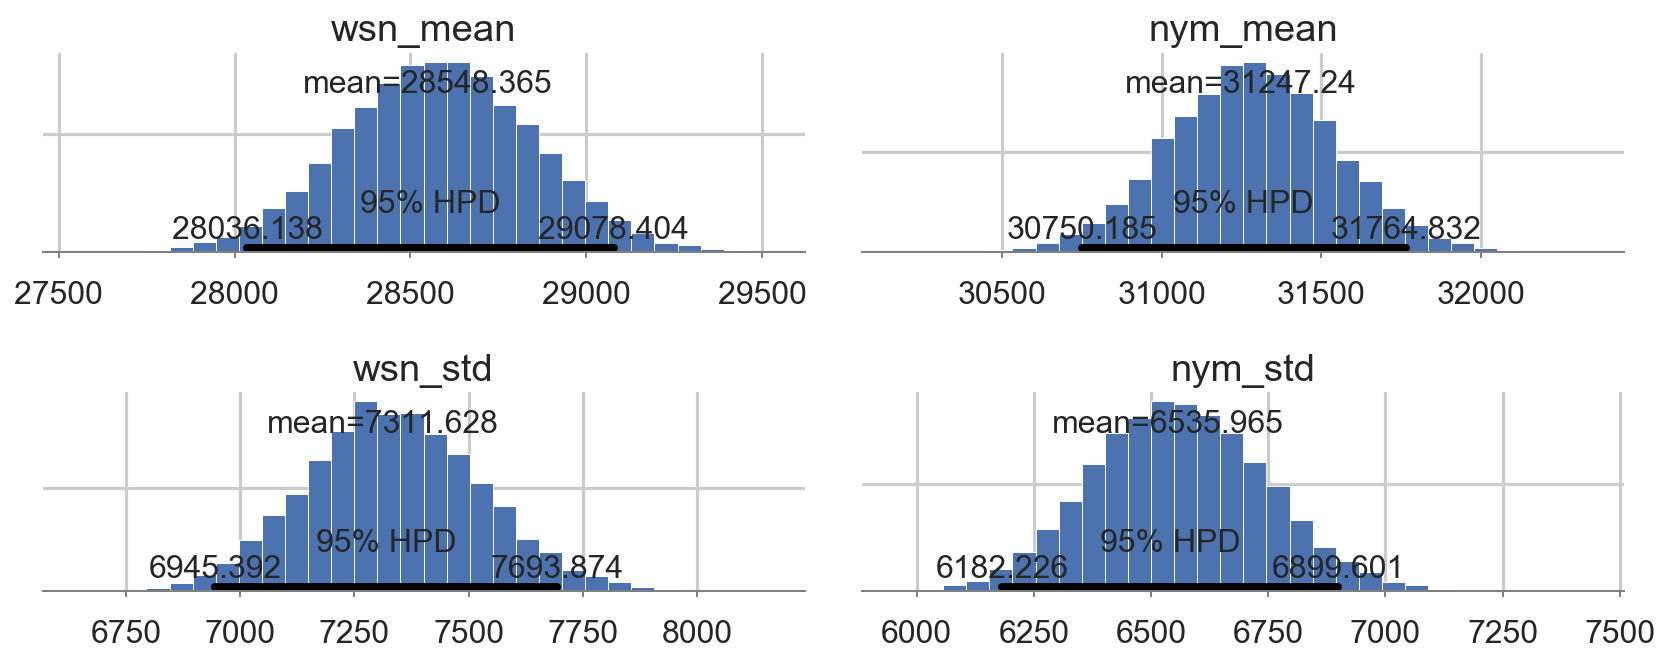

In [31]:
pm.plot_posterior(trace[3000:], varnames=['wsn_mean', 'nym_mean', 'wsn_std', 'nym_std'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11e885550>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11f0aef50>], dtype=object)

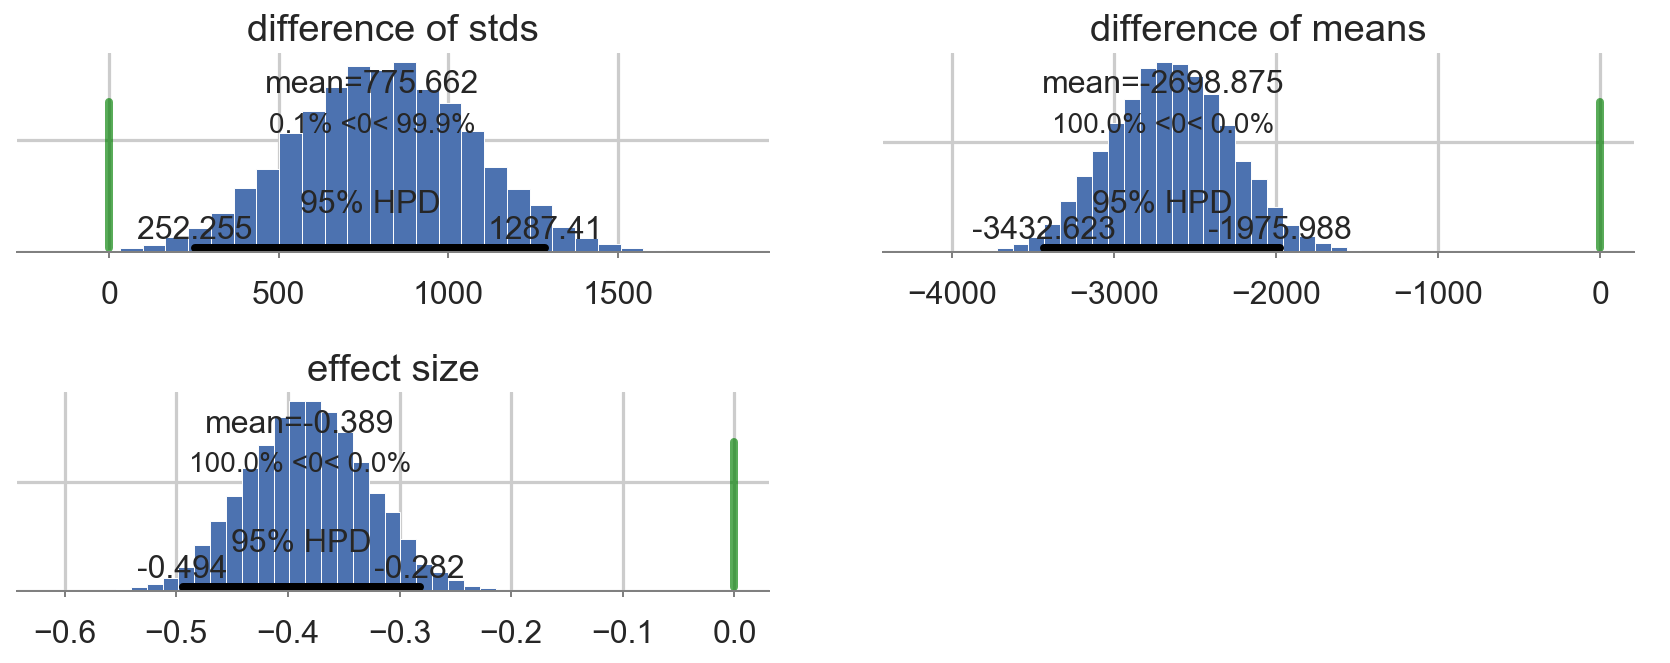

In [32]:
pm.plot_posterior(trace[3000:], varnames=['difference of means', 'difference of stds', 'effect size'], ref_val=0)